### IMPORTING THE DATA SCIENCE WORKING TOOLS

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use("seaborn-poster")
style.use('seaborn-whitegrid')
import seaborn as sns
import sqlite3
from xgboost import XGBRegressor
from xgboost import plot_importance

### A LITTLE DATA CLEANING AND DATE ENRICHING WITH PANDAS

In [98]:
# Cleaning expenses
df = pd.read_excel("dataset/2021-expenses-breakdown.xlsx")
df.drop("Unnamed: 5", axis=1, inplace=True)

df.to_csv('dataset/2021-expenses-breakdown2.csv', index=False)
df_tmp = pd.read_csv("dataset/2021-expenses-breakdown2.csv", parse_dates=['Date'])

df_tmp["Year"] = df_tmp['Date'].dt.year
df_tmp["Month"] = df_tmp['Date'].dt.month
df_tmp['Day'] = df_tmp['Date'].dt.day
df_tmp.drop("Date", axis=1, inplace=True)
df_tmp.to_csv('dataset/2021-expenses-breakdown3.csv', index=False)


# Cleaning income
df_tmp2 = pd.read_csv("dataset/2021-income-breakdown.txt", parse_dates=['Date'])

df_tmp2["Year"] = df_tmp2['Date'].dt.year
df_tmp2["Month"] = df_tmp2['Date'].dt.month
df_tmp2['Day'] = df_tmp2['Date'].dt.day
df_tmp2.drop("Date", axis=1, inplace=True)
df_tmp2.to_csv('dataset/2021-income-breakdown2.csv', index=False)

In [97]:
df_tmp2.head()

,Date,Category,Activity,Income
0,2021-01-03,Job,Sonafem,25000
1,2021-02-04,Job,Sonafem,25000
2,2021-02-08,Freelance,Signature-Design,9200
3,2021-02-15,Cash-Gift,Unknown,500
4,2021-02-23,Cash-Gift,Unknown,500


### SAVING THE ENRICHED DATAFRAME INTO AN SQLITE DATABASE TO ALLOW SQL TOOLS ON IT

### PUTTING `EXPENSES` INTO AN `EXPENSES_2021`  TABLE IN `MONEY.SQLITE` DATABASE

In [88]:
import sqlite3


connection = sqlite3.connect('money.sqlite')
cursor = connection.cursor()

cursor.execute("""DROP TABLE IF EXISTS expenses_2021""")
cursor.execute("""CREATE TABLE expenses_2021 ( category Text, subcategory Text, activity Text,  
                                                expenses INTEGER, year INTEGER, month INTEGER, day INTEGER)""")


fhand =  open("dataset/2021-expenses-breakdown3.csv")
print("Connected to expenses.breakdown")


c = []
for line in fhand:
    a = line.strip()
    b = a.split(',')
    c.append(b)    
    
for entry in c[1:]:
    
    category= entry[0]
    subcategory = entry[1]
    activity = entry[2]
    expenses = entry[3]
    year= entry[4]
    month = entry[5]
    day = entry[6]
    
    cursor.execute("""INSERT INTO expenses_2021 (category, subcategory, activity, expenses, year, month, day) 
    VALUES (?, ?, ?, ?, ?, ?, ?)""", (str(category), str(subcategory), str(activity), expenses, year, month, day) )
    
    connection.commit()

cursor.close()

print('Job Done')

Connected to expenses.breakdown
Job Done


### PUTTING `INCOME` INTO AN  `INCOME_2021` TABLE INTHE `MONEY.SQLITE` DATABASE

In [100]:
connection = sqlite3.connect('money.sqlite')
cursor = connection.cursor()

cursor.execute("""DROP TABLE IF EXISTS income_2021""")
cursor.execute("""CREATE TABLE income_2021 ( category Text, activity Text,  
                                                income INTEGER, year INTEGER, month INTEGER, day INTEGER)""")


fhand =  open("dataset/2021-income-breakdown2.csv")
print("Connected to income-breakdown")


c = []
for line in fhand:
    a = line.strip()
    b = a.split(',')
    c.append(b)    
    
for entry in c[1:]:
    
    category= entry[0]
    activity = entry[1]
    income = entry[2]
    year= entry[3]
    month = entry[4]
    day = entry[5]
    
    cursor.execute("""INSERT INTO income_2021 (category, activity, income, year, month, day) 
    VALUES (?, ?, ?, ?, ?, ?)""", (str(category), str(activity), income, year, month, day) )
    
    connection.commit()

cursor.close()

print('Job Done')

Connected to income-breakdown
Job Done


### READING DATA FROM THE TABLES IN THE DATABASE INTO  A PANDAS DATAFRAME

In [4]:
connection = sqlite3.connect('money.sqlite')
cursor = connection.cursor()
query = """SELECT month, subcategory, SUM(expenses) AS expenses FROM expenses_2021 GROUP BY 1, 2"""
query2 = """ SELECT month, SUM(expenses)  AS total_expenses  FROM expenses_2021 GROUP BY 1"""
query3 = """SELECT month, SUM(income) AS  total_income FROM income_2021 GROUP BY 1"""



df = pd.read_sql_query(query, con=connection)
total_expenses = pd.read_sql_query(query2, con=connection)
total_income = pd.read_sql_query(query3, con=connection)

# income has records for Jan, March and April but Expenses were not recorded
# The code below is to ensure that our comparisons are consistent across months that has records for both income and expenses
total_income.drop(labels=[0,2,3], axis=0, inplace=True)


connection.commit()
cursor.close()

In [5]:
df.head()

,month,subcategory,expenses
0,2,Alms,500.0
1,2,Food,4500.0
2,2,Haircut,450.0
3,2,Pleasure,950.0
4,2,Random,11450.0


### FEATURE ENGINEERING TO ENABLE US CARRY OUT EXPERIMENT AND MACHINE LEARNING

In [6]:
matrix = df.pivot_table(index='month', columns='subcategory', values='expenses')
matrix.fillna(0, inplace=True)

# Cleaning disjointed column names from the Pivot-table
matrix.columns = [''.join(str(s).strip() for s in col if s) for col in list(matrix.columns)]
matrix.reset_index(inplace=True)
matrix['Total-Expenses'] = list(total_expenses['total_expenses'])
matrix['Total-Income'] = list(total_income['total_income'])
matrix['Savings'] = matrix['Total-Income']- matrix['Total-Expenses']
matrix.to_csv("2021_expenses_engineered.csv", index=False)
matrix.T

,0,1,2,3,4,5,6,7,8
month,2.0,5.0,6.0,7.00,8.00,9.00,10.00,11.00,12.00
Alms,500.0,2900.0,1600.0,2200.00,700.00,550.00,2290.00,1930.00,9835.75
BankCharge,0.0,0.0,0.0,92.49,1287.89,200.00,416.40,153.76,412.43
Clothing,0.0,250.0,8120.0,4400.00,6651.50,150.00,300.00,700.00,600.00
Education,0.0,2000.0,0.0,0.00,0.00,0.00,23321.11,4712.46,9670.73
Electronic,0.0,0.0,500.0,0.00,0.00,0.00,0.00,1100.00,0.00
Family,0.0,2000.0,5210.0,20200.00,7021.50,0.00,0.00,0.00,10300.00
Food,4500.0,5430.0,7150.0,8740.00,10240.00,8740.00,8260.00,11200.00,12170.00
Haircut,450.0,300.0,300.0,300.00,600.00,300.00,300.00,300.00,300.00
Maintenance,0.0,70.0,100.0,0.00,0.00,0.00,0.00,0.00,0.00


### DESCRIPTIVE STATISTICS

In [14]:
matrix.describe().T

,count,mean,std,min,25%,50%,75%,max
month,9.0,7.777778,3.153481,2.00,6.00,8.00,10.00,12.00
Alms,9.0,2500.638889,2878.470175,500.00,700.00,1930.00,2290.00,9835.75
BankCharge,9.0,284.774444,409.950652,0.00,0.00,153.76,412.43,1287.89
Clothing,9.0,2352.388889,3177.228566,0.00,250.00,600.00,4400.00,8120.00
Education,9.0,4411.588889,7813.813257,0.00,0.00,0.00,4712.46,23321.11
Electronic,9.0,177.777778,383.333333,0.00,0.00,0.00,0.00,1100.00
Family,9.0,4970.166667,6821.405207,0.00,0.00,2000.00,7021.50,20200.00
Food,9.0,8492.222222,2529.974198,4500.00,7150.00,8740.00,10240.00,12170.00
Haircut,9.0,350.000000,106.066017,300.00,300.00,300.00,300.00,600.00
Maintenance,9.0,18.888889,38.224483,0.00,0.00,0.00,0.00,100.00


### `INCOME` VS `EXPENSES` VS `SAVINGS` ACROSS MONTHS TRACKED

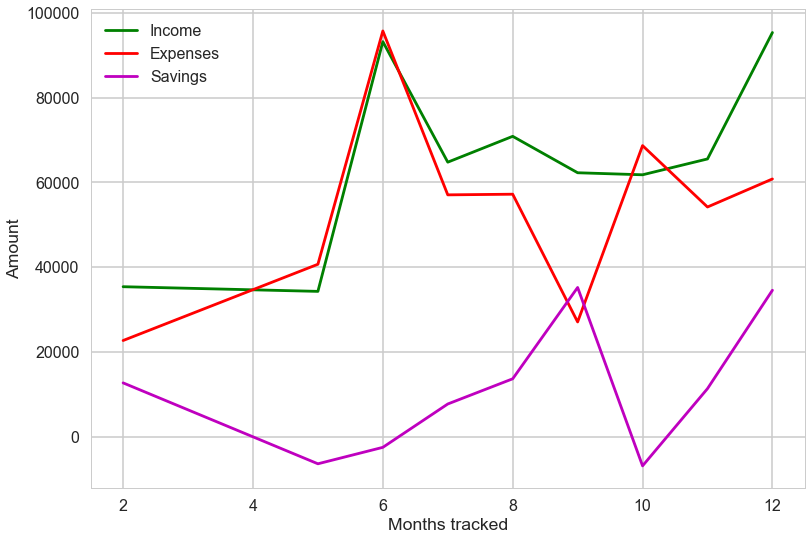

In [10]:
fig, ax = plt.subplots()
plt.plot(matrix["month"], matrix["Total-Income"], c='g')
plt.plot(matrix["month"], matrix["Total-Expenses"], c='r')
plt.plot(matrix['month'], matrix['Savings'], c='m')
plt.xlabel("Months tracked")
plt.ylabel("Amount")
plt.legend(["Income", "Expenses", "Savings"])
plt.show()

### UNDERSTANDING THE PRESENCE OF `OUTLIERS` IN `HOW MONEY WAS SPENT ON EACH FEATURE` ACROSS THE MONTHS

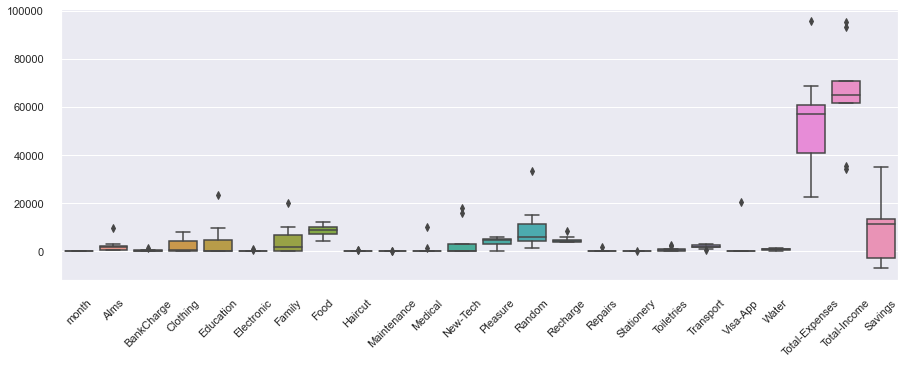

In [12]:
import seaborn as sns
sns.set(rc={"figure.figsize":(15,5)})
ax = sns.boxplot(data=matrix)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

### CORRELATION MATRIX EXPLAININING RELATIONSHIP BETWEEN THE FEATURES

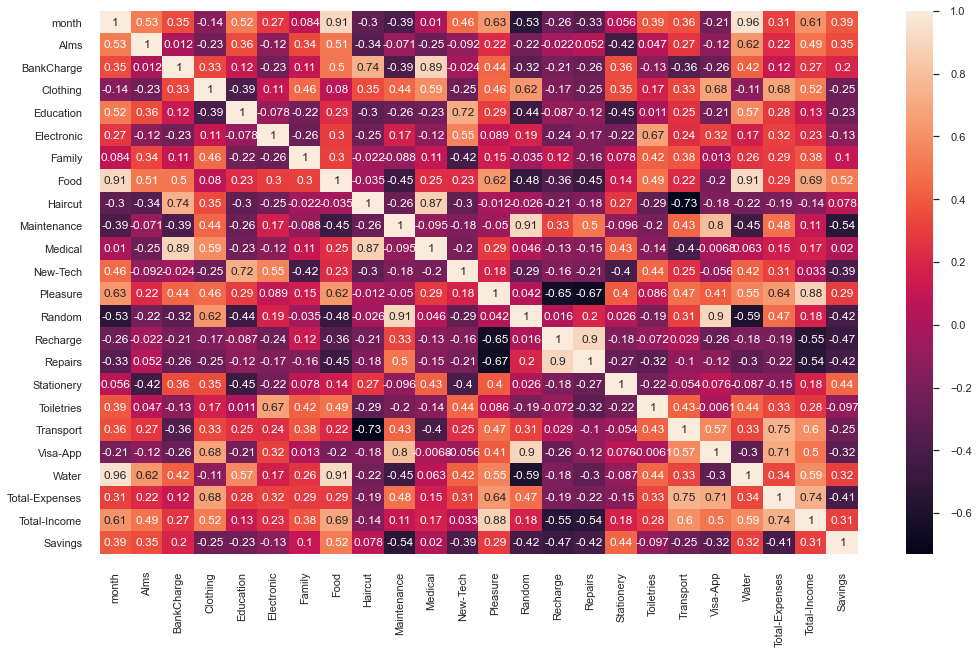

In [25]:
correlation_matrix = matrix.corr()
sns.set({"figure.figsize": (17,10)})
sns.heatmap(correlation_matrix, annot=True);

### FEW TAKE AWAY POINTS FROM THE  CORRELATION MATRIX
1. `Food` and `Water` are highly correlated positively to `month` and to each other at a percentage above 90%
2. ALSO THERE ARE CHANCES THAT AS `INCOME` INCREASED
* Money spent on `food` increased by `69 percent`
* `Overall expenses` increased by `74 percent`
* `Going on eat outs (pleasure)` increased by `88 percent`
* `Money sent to Family (family)` increased by `38 percent`
* `Money spent on clothes(clothing)` increased by `52 percent`
* `Almsgiving` increased  by `49 percent`
* Chances that `income increased across the months` was 61 percent

###### THERE ARE ALSO MANY RELATIONSHIPS TO BE DISCOVERED USING THE MATRIX ABOVE

### MACHINE LEARNING WITH XGBOOST TO ASCERTAIN WHICH FEATURE IS LIKELY TO HAVE MORE EFFECT ON TOTAL EXPENSES GOING FORWARD

Xgboost r2 Score: 0.9999999999998067


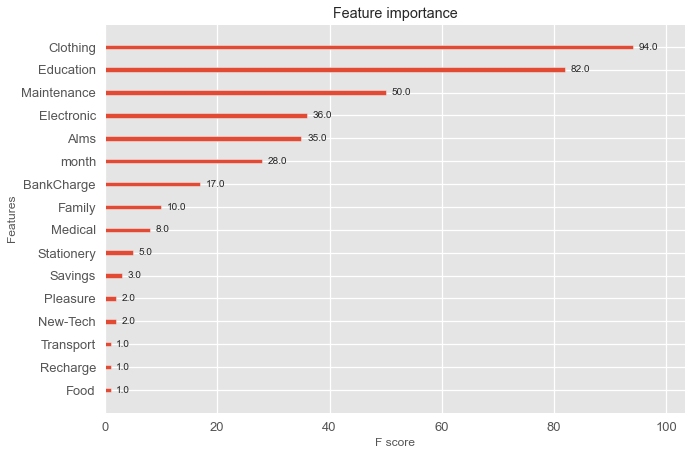

In [33]:
style.use("seaborn-talk")
style.use("ggplot")


X = matrix.drop("Total-Expenses", axis=1)
y = matrix['Total-Expenses']

model =  XGBRegressor().fit(X, y)
plot_importance(model);
print(f"Xgboost r2 Score: {model.score(X,y)}")

### USING `RANDOM-FOREST-REGRESSOR` FOR THE SAME PURPOSE

RandomForest R2 Score: 0.8528207527513534


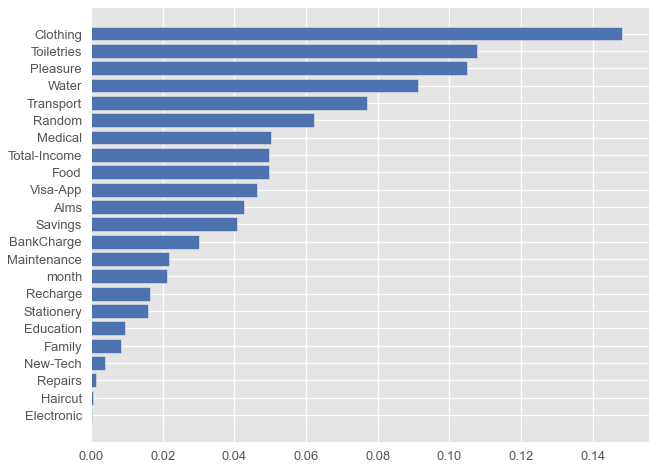

In [37]:
from sklearn.ensemble import RandomForestRegressor

np.random.seed(42)

rf2 = RandomForestRegressor().fit(X,y)

columns = list(X.columns)
coefficients = rf2.feature_importances_

R2 = rf2.score(X, y)
print("RandomForest R2 Score:", R2)

# Map coefficients to columns and convert to Dataframe
coef_df = pd.DataFrame({"Columns": columns, "Feature_Importance": coefficients})
sorted_df = coef_df.sort_values("Feature_Importance", ascending=False)

# Visualize the feature importances
fig, ax = plt.subplots(figsize=(10 ,8))
ax = ax.barh(sorted_df["Columns"], sorted_df["Feature_Importance"], color=['b'])
plt.gca().invert_yaxis()
plt.show()

### USING A SIMPLER MODEL `LINEAR-REGRESSION`

Linear Model R2 Score: 1.0


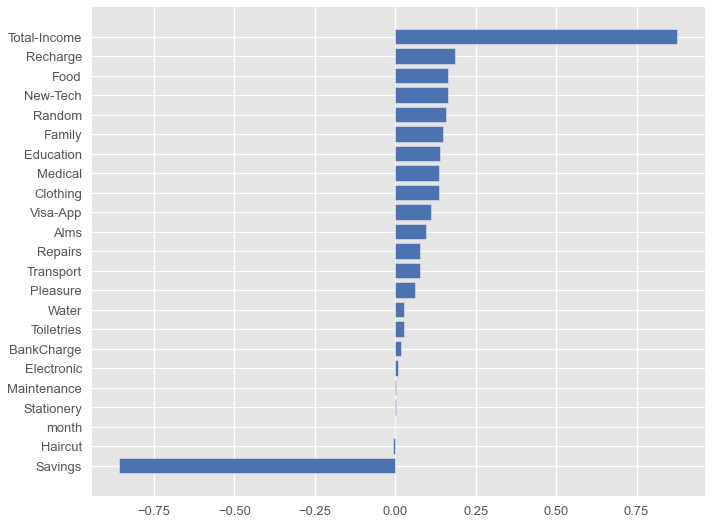

In [40]:
from sklearn.linear_model import LinearRegression


model = LinearRegression().fit(X,y)

R2 = model.score(X, y)
print('Linear Model R2 Score:', R2)

columns = list(X.columns)
coefficients = model.coef_
coef_df = pd.DataFrame({"Columns": columns, "Feature_Importance": coefficients})
sorted_df = coef_df.sort_values("Feature_Importance", ascending=False)

fig, ax = plt.subplots(figsize=(11,9))
ax = ax.barh(sorted_df["Columns"], sorted_df["Feature_Importance"], color=['b'])
plt.gca().invert_yaxis()
plt.show()